In [2]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import random
import simpy
import matplotlib.pyplot as plt
from scipy.stats import norm

# Constants
NUM_TIMESTEPS = 50
CUSTOMER_DEMAND = [100000, 150000, 200000]
DEMAND_PROBABILITIES = [0.15, 0.15, 0.7]
LEAD_TIME_MIN = 1
LEAD_TIME_MAX = 4
CASE_HOLDING_COST = 0.5
MISSING_ORDER_COST = 1


class BeerEntity:
    def __init__(self, env, name, downstream_entity=None, upstream_entity=None, initial_inventory=0):
        self.env = env
        self.name = name
        self.downstream_entity = downstream_entity
        self.upstream_entity = upstream_entity
        self.inventory = initial_inventory
        self.costs = []
        self.orders = []
        self.inventory_levels = []
        self.production_order = 0  
        self.production_data = []
        self.mu = 0
        self.sigma = 0
        # Start the entity's process
        self.action = env.process(self.run())

    def calculate_demand(self):
        # Use random.choices() to calculate demand based on probabilities
        demand = random.choices(CUSTOMER_DEMAND, DEMAND_PROBABILITIES)[0]
        return demand

    def place_order(self):
        # Calculate lead time
        lead_time = random.randint(LEAD_TIME_MIN, LEAD_TIME_MAX)
       
        # Wait for lead time
        yield self.env.timeout(lead_time)
       
        # Calculate the optimal order quantity
        criticalRatio = MISSING_ORDER_COST/(MISSING_ORDER_COST+CASE_HOLDING_COST)
        optimalQuantity = round(self.sigma*norm.ppf(criticalRatio) + self.mu,0)
        
        # Place order to downstream entity
        if self.name == 'Factory' and self.upstream_entity:
            order = optimalQuantity
        elif self.downstream_entity:
            order = optimalQuantity
        else:
            order = 0

        if self.name == 'Distributor':
            self.upstream_entity.production_order = order

        self.inventory += order
        return order  

    def receive_order(self):
        # Return the order quantity
        return random.choices(CUSTOMER_DEMAND, DEMAND_PROBABILITIES)[0]
           
    def run(self):
        # Prepare demand history for calculating mean and standard deviation
        demand_history = []
        
        for timestep in range(NUM_TIMESTEPS):
            # If it is factory, it produce beers each week based on oreders made by distributors
            if self.name == 'Factory':
                production =  self.production_order
                self.inventory += production
                self.production_data.append(production)

            # Calculate demand
            demand = self.calculate_demand()
            demand_history.append(demand)
            self.mu = sum(demand_history) / len(demand_history) 
            self.sigma = (sum((i - self.mu) ** 2 for i in demand_history) / len(demand_history)) ** 0.5
           
            # Check if inventory is enough to meet the demand
            if self.inventory >= demand:
                self.inventory -= demand
            else:
                # Calculate missing order cost
                missing_order_cost = (demand - self.inventory) * MISSING_ORDER_COST
                self.costs.append(missing_order_cost)
                self.inventory = 0
           
            # Calculate case holding cost
            case_holding_cost = self.inventory * CASE_HOLDING_COST
            self.costs.append(case_holding_cost)
           
            # Place order to downstream entity
            order = yield from self.place_order()
            self.orders.append(order)
            yield self.env.timeout(1)  # Move to next timestep
            self.inventory_levels.append(self.inventory)
            self.orders.append(order)


# Create the simulation environment
env = simpy. Environment()

# Create entities with initial inventory
factory = BeerEntity(env, 'Factory', initial_inventory=150000)
distributor = BeerEntity(env, 'Distributor', downstream_entity=factory, upstream_entity=factory, initial_inventory=150000)
wholesaler = BeerEntity(env, 'Wholesaler', downstream_entity=distributor, initial_inventory=150000)
retailer = BeerEntity(env, 'Retailer', downstream_entity=wholesaler, initial_inventory=150000)
customer = BeerEntity(env, 'Customer', downstream_entity=retailer)

# Run the simulation
env.run()

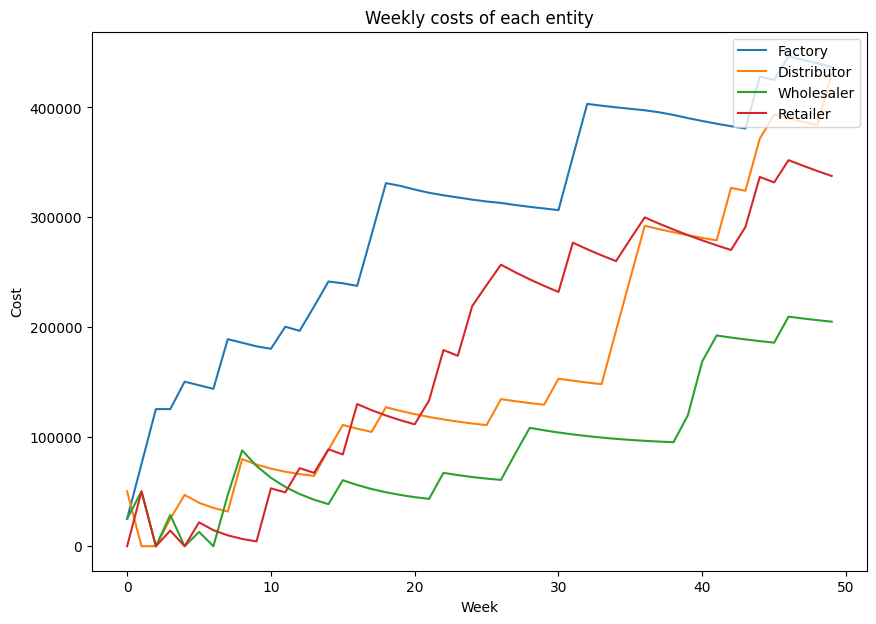

In [4]:
# Plot the weekly costs of each entity
plt.figure(figsize=(10, 7))

plt.plot(range(NUM_TIMESTEPS), factory.costs[:NUM_TIMESTEPS], label='Factory')
plt.plot(range(NUM_TIMESTEPS), distributor.costs[:NUM_TIMESTEPS], label='Distributor')
plt.plot(range(NUM_TIMESTEPS), wholesaler.costs[:NUM_TIMESTEPS], label='Wholesaler')
plt.plot(range(NUM_TIMESTEPS), retailer.costs[:NUM_TIMESTEPS], label='Retailer')

plt.title('Weekly costs of each entity')
plt.xlabel('Week')
plt.ylabel('Cost')
plt.legend(loc='upper right')

plt.show()

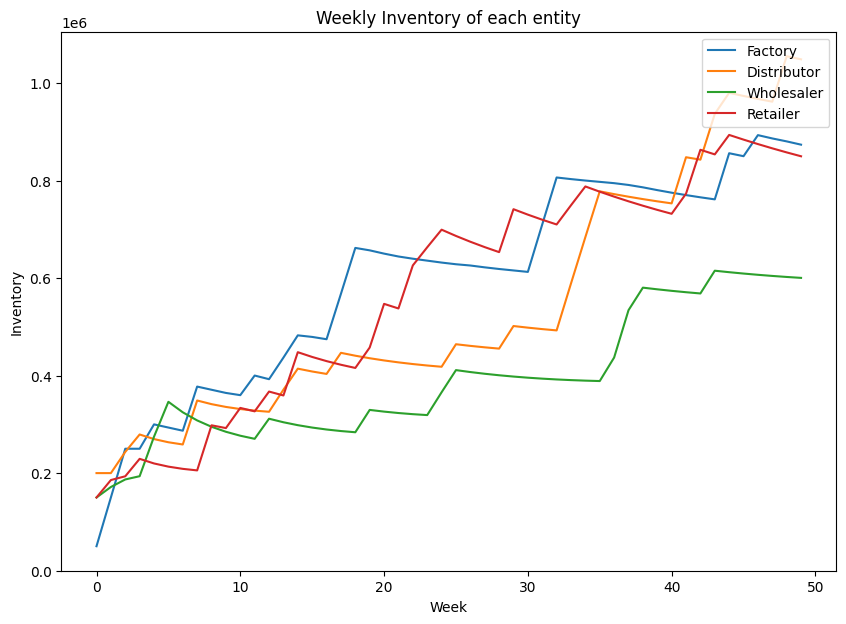

In [5]:

# Plot the inventory of each entity    
plt.figure(figsize=(10, 7))

plt.plot(range(NUM_TIMESTEPS), factory.inventory_levels[:NUM_TIMESTEPS], label='Factory')
plt.plot(range(NUM_TIMESTEPS), distributor.inventory_levels[:NUM_TIMESTEPS], label='Distributor')
plt.plot(range(NUM_TIMESTEPS), wholesaler.inventory_levels[:NUM_TIMESTEPS], label='Wholesaler')
plt.plot(range(NUM_TIMESTEPS), retailer.inventory_levels[:NUM_TIMESTEPS], label='Retailer')

plt.title('Weekly Inventory of each entity')
plt.xlabel('Week')
plt.ylabel('Inventory')
plt.legend(loc='upper right')

plt.show()

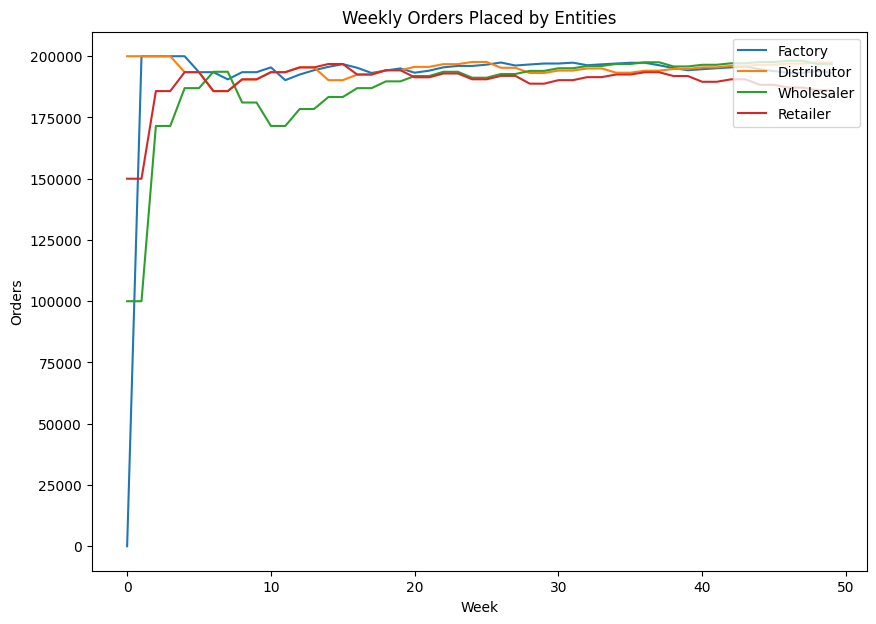

In [6]:
# Plot the orders placed by each entity
plt.figure(figsize=(10, 7))
plt.plot(range(NUM_TIMESTEPS), factory.production_data[:NUM_TIMESTEPS], label='Factory')
plt.plot(range(NUM_TIMESTEPS), distributor.orders[:NUM_TIMESTEPS], label='Distributor')
plt.plot(range(NUM_TIMESTEPS), wholesaler.orders[:NUM_TIMESTEPS], label='Wholesaler')
plt.plot(range(NUM_TIMESTEPS), retailer.orders[:NUM_TIMESTEPS], label='Retailer')

plt.xlabel('Week')
plt.ylabel('Orders')
plt.title('Weekly Orders Placed by Entities')
plt.legend(loc='upper right')

plt.show()